In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('heart.csv')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [3]:
categorical_val = []
continuous_val = []
for col in df.columns:
    if len(df[col].unique()) <= 10:
        categorical_val.append(col)
    else:
        continuous_val.append(col)

In [4]:
categorical_val.remove('target')
dataset = pd.get_dummies(df, columns = categorical_val)
dataset.head()

,age,trestbps,chol,thalach,oldpeak,target,sex_0,sex_1,cp_0,cp_1,...,slope_2,ca_0,ca_1,ca_2,ca_3,ca_4,thal_0,thal_1,thal_2,thal_3
0,63,145,233,150,2.3,1,0,1,0,0,...,0,1,0,0,0,0,0,1,0,0
1,37,130,250,187,3.5,1,0,1,0,0,...,0,1,0,0,0,0,0,0,1,0
2,41,130,204,172,1.4,1,1,0,0,1,...,1,1,0,0,0,0,0,0,1,0
3,56,120,236,178,0.8,1,0,1,0,1,...,1,1,0,0,0,0,0,0,1,0
4,57,120,354,163,0.6,1,1,0,1,0,...,1,1,0,0,0,0,0,0,1,0


In [5]:
from sklearn.preprocessing import StandardScaler

s_sc = StandardScaler()
col_to_scale = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
dataset[col_to_scale] = s_sc.fit_transform(dataset[col_to_scale])

In [6]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

def print_score(clf, x_train, y_train, x_test, y_test, train):
    if train == True:
        pred = clf.predict(x_train)
        clf_report = pd.DataFrame(classification_report(y_train, pred, output_dict=True))
        print(f'Accuracy Score: {accuracy_score(y_train, pred) * 100:.4f}%')
        print('______________________________________________________________________')
        print(f'Classification Report:\n{clf_report}')
#         print('______________________________________________________________________')
#         print(f'Confusion Matrix: \n {confusion_matrix(y_train, pred)}\n')
    elif train == False:
        pred = clf.predict(x_test)
        clf_report = pd.DataFrame(classification_report(y_test, pred, output_dict=True))
        print(f'Accuracy Score: {accuracy_score(y_test, pred) * 100:.4f}%')
        print('______________________________________________________________________')
        print(f'Classification Report:\n{clf_report}')
#         print('______________________________________________________________________')
#         print(f'Confusion Matrix: \n {confusion_matrix(y_test, pred)}\n')

In [7]:
from sklearn.model_selection import train_test_split

x = dataset.drop('target', axis=1)
y = dataset.target
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

### 1. Logistic regression

#### 1.1. Non hyperparameter tuning

In [8]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(solver='liblinear').fit(x_train, y_train)

In [9]:
print_score(lr_clf, x_train, y_train, x_test, y_test, train=True)

Accuracy Score: 86.7925%
______________________________________________________________________
Classification Report:
                   0           1  accuracy   macro avg  weighted avg
precision   0.879121    0.859504  0.867925    0.869313      0.868480
recall      0.824742    0.904348  0.867925    0.864545      0.867925
f1-score    0.851064    0.881356  0.867925    0.866210      0.867496
support    97.000000  115.000000  0.867925  212.000000    212.000000


In [10]:
print_score(lr_clf, x_train, y_train, x_test, y_test, train=False)

Accuracy Score: 86.8132%
______________________________________________________________________
Classification Report:
                   0          1  accuracy  macro avg  weighted avg
precision   0.871795   0.865385  0.868132   0.868590      0.868273
recall      0.829268   0.900000  0.868132   0.864634      0.868132
f1-score    0.850000   0.882353  0.868132   0.866176      0.867776
support    41.000000  50.000000  0.868132  91.000000     91.000000


#### 1.2. Using hyperparameter tuning

In [11]:
from sklearn.model_selection import GridSearchCV

params = {'C': np.logspace(-4, 5, 20), 'solver': ['liblinear']}
lr_cv = GridSearchCV(LogisticRegression(), params, scoring='accuracy', n_jobs=1, verbose=1, cv=5)
lr_cv.fit(x_train, y_train)
lr_cv.best_params_

Fitting 5 folds for each of 20 candidates, totalling 100 fits


{'C': 0.2069138081114788, 'solver': 'liblinear'}

In [12]:
lr_clf_tuning = LogisticRegression(**lr_cv.best_params_).fit(x_train, y_train)

In [13]:
print_score(lr_clf_tuning, x_train, y_train, x_test, y_test, train=True)

Accuracy Score: 85.8491%
______________________________________________________________________
Classification Report:
                   0           1  accuracy   macro avg  weighted avg
precision   0.860215    0.857143  0.858491    0.858679      0.858549
recall      0.824742    0.886957  0.858491    0.855849      0.858491
f1-score    0.842105    0.871795  0.858491    0.856950      0.858210
support    97.000000  115.000000  0.858491  212.000000    212.000000


In [14]:
print_score(lr_clf_tuning, x_train, y_train, x_test, y_test, train=False)

Accuracy Score: 85.7143%
______________________________________________________________________
Classification Report:
                   0          1  accuracy  macro avg  weighted avg
precision   0.850000   0.862745  0.857143   0.856373      0.857003
recall      0.829268   0.880000  0.857143   0.854634      0.857143
f1-score    0.839506   0.871287  0.857143   0.855397      0.856968
support    41.000000  50.000000  0.857143  91.000000     91.000000


In [34]:
lr_clf_train = accuracy_score(y_train, lr_clf.predict(x_train)) * 100
lr_clf_test = accuracy_score(y_test, lr_clf.predict(x_test)) * 100
lr_clf_tuning_train = accuracy_score(y_train, lr_clf_tuning.predict(x_train)) * 100
lr_clf_tuning_test = accuracy_score(y_test, lr_clf_tuning.predict(x_test)) * 100

result = pd.DataFrame(columns=['Model', 'Non-tuning train accuracy %', 'Tuning train accuracy %', 'Non-tuning test accuracy %', 'Tuning test accuracy %'])
lr_result = pd.DataFrame(data=[['Logistic regression', lr_clf_train, lr_clf_tuning_train, lr_clf_test, lr_clf_tuning_test]],
                        columns=['Model', 'Non-tuning train accuracy %', 'Tuning train accuracy %', 'Non-tuning test accuracy %', 'Tuning test accuracy %'])
result = result.append(lr_result, ignore_index=True)
result

,Model,Non-tuning train accuracy %,Tuning train accuracy %,Non-tuning test accuracy %,Tuning test accuracy %
0,Logistic regression,86.792453,85.849057,86.813187,85.714286


### 2. K-nearest neighbors

#### 2.1. Non hyperparameter tuning

In [35]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier().fit(x_train, y_train)

In [36]:
print_score(knn_clf, x_train, y_train, x_test, y_test, train=True)

Accuracy Score: 86.7925%
______________________________________________________________________
Classification Report:
                   0           1  accuracy   macro avg  weighted avg
precision   0.863158    0.871795  0.867925    0.867476      0.867843
recall      0.845361    0.886957  0.867925    0.866159      0.867925
f1-score    0.854167    0.879310  0.867925    0.866739      0.867806
support    97.000000  115.000000  0.867925  212.000000    212.000000


In [37]:
print_score(knn_clf, x_train, y_train, x_test, y_test, train=False)

Accuracy Score: 86.8132%
______________________________________________________________________
Classification Report:
                   0      1  accuracy  macro avg  weighted avg
precision   0.853659   0.88  0.868132   0.866829      0.868132
recall      0.853659   0.88  0.868132   0.866829      0.868132
f1-score    0.853659   0.88  0.868132   0.866829      0.868132
support    41.000000  50.00  0.868132  91.000000     91.000000


#### 2.2. Using hyperparameter tuning

In [38]:
train_score = []
test_score = []
neighbors = range(1, 30)

for k in neighbors:
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(x_train, y_train)
    train_score.append(accuracy_score(y_train, model.predict(x_train)))
#     test_score.append(accuracy_score(y_test, model.predict(x_test)))

Maximum KNN score on the test data: 100.00%


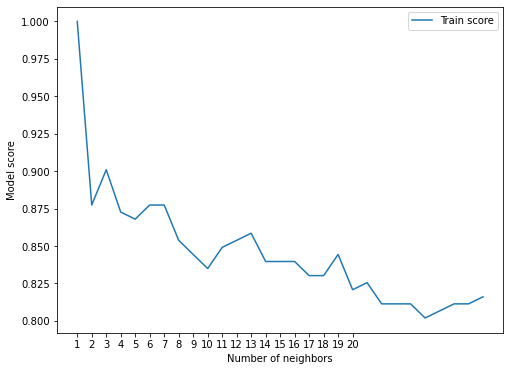

In [39]:
plt.figure(figsize=(8,6))

plt.plot(neighbors, train_score, label="Train score")
# plt.plot(neighbors, test_score, label="Test score")
plt.xticks(np.arange(1, 21, 1))
plt.xlabel("Number of neighbors")
plt.ylabel("Model score")
plt.legend()

print(f"Maximum KNN score on the test data: {max(train_score)*100:.2f}%")

In [40]:
knn_clf_tuning = KNeighborsClassifier(n_neighbors=27).fit(x_train, y_train)

In [41]:
print_score(knn_clf_tuning, x_train, y_train, x_test, y_test, train=True)

Accuracy Score: 81.1321%
______________________________________________________________________
Classification Report:
                   0           1  accuracy   macro avg  weighted avg
precision   0.835294    0.795276  0.811321    0.815285      0.813586
recall      0.731959    0.878261  0.811321    0.805110      0.811321
f1-score    0.780220    0.834711  0.811321    0.807465      0.809779
support    97.000000  115.000000  0.811321  212.000000    212.000000


In [42]:
print_score(knn_clf_tuning, x_train, y_train, x_test, y_test, train=False)

Accuracy Score: 87.9121%
______________________________________________________________________
Classification Report:
                   0          1  accuracy  macro avg  weighted avg
precision   0.894737   0.867925  0.879121   0.881331      0.880005
recall      0.829268   0.920000  0.879121   0.874634      0.879121
f1-score    0.860759   0.893204  0.879121   0.876982      0.878586
support    41.000000  50.000000  0.879121  91.000000     91.000000


In [43]:
knn_clf_test = accuracy_score(y_test, knn_clf.predict(x_test)) * 100
knn_clf_train = accuracy_score(y_train, knn_clf.predict(x_train)) * 100
knn_clf_tuning_test = accuracy_score(y_test, knn_clf_tuning.predict(x_test)) * 100
knn_clf_tuning_train = accuracy_score(y_train, knn_clf_tuning.predict(x_train)) * 100

knn_result = pd.DataFrame(data=[['K-nearest neighbors', knn_clf_train, knn_clf_tuning_train, knn_clf_test, knn_clf_tuning_test]],
                        columns=['Model', 'Non-tuning train accuracy %', 'Tuning train accuracy %', 'Non-tuning test accuracy %', 'Tuning test accuracy %'])
result = result.append(knn_result, ignore_index=True)
result

,Model,Non-tuning train accuracy %,Tuning train accuracy %,Non-tuning test accuracy %,Tuning test accuracy %
0,Logistic regression,86.792453,85.849057,86.813187,85.714286
1,K-nearest neighbors,86.792453,81.132075,86.813187,87.912088


### Support vector machine

In [25]:
from sklearn.svm import SVC

svm_clf = SVC(kernel='rbf', gamma=0.1, C=1.0).fit(x_train, y_train)

In [26]:
print_score(svm_clf, x_train, y_train, x_test, y_test, train=True)

Accuracy Score: 93.3962%
______________________________________________________________________
Classification Report:
                   0           1  accuracy   macro avg  weighted avg
precision   0.936842    0.931624  0.933962    0.934233      0.934011
recall      0.917526    0.947826  0.933962    0.932676      0.933962
f1-score    0.927083    0.939655  0.933962    0.933369      0.933903
support    97.000000  115.000000  0.933962  212.000000    212.000000


In [27]:
print_score(svm_clf, x_train, y_train, x_test, y_test, train=False)

Accuracy Score: 87.9121%
______________________________________________________________________
Classification Report:
                   0          1  accuracy  macro avg  weighted avg
precision   0.857143   0.897959  0.879121   0.877551      0.879569
recall      0.878049   0.880000  0.879121   0.879024      0.879121
f1-score    0.867470   0.888889  0.879121   0.878179      0.879239
support    41.000000  50.000000  0.879121  91.000000     91.000000


### Decision tree classifier

In [28]:
from sklearn.tree import DecisionTreeClassifier

tree_clf = DecisionTreeClassifier(random_state=42).fit(x_train, y_train)

In [29]:
print_score(tree_clf, x_train, y_train, x_test, y_test, train=True)

Accuracy Score: 100.0000%
______________________________________________________________________
Classification Report:
              0      1  accuracy  macro avg  weighted avg
precision   1.0    1.0       1.0        1.0           1.0
recall      1.0    1.0       1.0        1.0           1.0
f1-score    1.0    1.0       1.0        1.0           1.0
support    97.0  115.0       1.0      212.0         212.0


In [30]:
print_score(tree_clf, x_train, y_train, x_test, y_test, train=False)

Accuracy Score: 78.0220%
______________________________________________________________________
Classification Report:
                   0          1  accuracy  macro avg  weighted avg
precision   0.723404   0.840909   0.78022   0.782157      0.787967
recall      0.829268   0.740000   0.78022   0.784634      0.780220
f1-score    0.772727   0.787234   0.78022   0.779981      0.780698
support    41.000000  50.000000   0.78022  91.000000     91.000000


### Random forest

In [1]:
from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import RandomizedSearchCV

rf_clf = RandomForestClassifier(n_estimators=1000, random_state=42).fit(x_train, y_train)

NameError: name 'x_train' is not defined

In [32]:
print_score(rf_clf, x_train, y_train, x_test, y_test, train=True)

Accuracy Score: 100.0000%
______________________________________________________________________
Classification Report:
              0      1  accuracy  macro avg  weighted avg
precision   1.0    1.0       1.0        1.0           1.0
recall      1.0    1.0       1.0        1.0           1.0
f1-score    1.0    1.0       1.0        1.0           1.0
support    97.0  115.0       1.0      212.0         212.0


In [33]:
print_score(rf_clf, x_train, y_train, x_test, y_test, train=False)

Accuracy Score: 82.4176%
______________________________________________________________________
Classification Report:
                   0      1  accuracy  macro avg  weighted avg
precision   0.804878   0.84  0.824176   0.822439      0.824176
recall      0.804878   0.84  0.824176   0.822439      0.824176
f1-score    0.804878   0.84  0.824176   0.822439      0.824176
support    41.000000  50.00  0.824176  91.000000     91.000000
